In [1]:
import os
import re
import sys
import glob
import pickle
from time import strftime, localtime

import numpy as np

import matplotlib.pyplot as plt
plt.rc('font', **{'family': 'sans-serif', 'size': 9})

if '..' not in sys.path:
    sys.path.append('..')
from deep_utils import *

%matplotlib inline

In [14]:
def plot_data(data_folder, gen_id=None, area_id=None, bus_id=None, H_values = [2,10], xlim_distr = None, ylim=[-4,4]):
    if gen_id is None and (bus_id is None or area_id is None):
        raise Exception('One of gen_id or (bus_id,area_id) must be not None')
    if gen_id is not None and (bus_id is not None or area_id is not None):
        raise Exception('One of gen_id or (bus_id,area_id) must be None')

    H_values = np.array(H_values)
    
    if gen_id is not None:
        var_names = tuple(var_name.format(gen_id) for var_name in ('omega_G{}','Pe_G{}'))
        inertia = {'training': H_values}
        time, x, y = load_data([data_folder], [gen_id], inertia, var_names, max_block_size=500, use_tf=False)
    else:
        var_names = tuple(var_name.format(bus_id) for var_name in ('omegael_bus{}','Pe_bus{}'))
        data_files = []
        for data_file in glob.glob(data_folder + '/*_training_set.h5'):
            H = list(map(float, re.findall('\d+.\d+', os.path.basename(data_file))))
            if area_id == 1:
                H = np.mean(H[:2])
            else:
                H = np.mean(H[-2:])
            if H in H_values:
                data_files.append(data_file)
        time, x, y = load_data_two_area({'training': data_files}, var_names, max_block_size=1000, use_tf=False)

    x_train_mean = np.mean(x['training'], axis=(1,2))
    x_train_std = np.std(x['training'], axis=(1,2))
    for i,(m,s) in enumerate(zip(x_train_mean, x_train_std)):
        x['training'][i,:,:] = (x['training'][i,:,:] - m) / s
    
    fig = plt.figure(figsize=(7,4))
    gs = fig.add_gridspec(2, 3)
    ax = [
        fig.add_subplot(gs[0,:2]),
        fig.add_subplot(gs[1,:2]),
        fig.add_subplot(gs[0,2]),
        fig.add_subplot(gs[1,2])
    ]

    idx_min, _ = np.where(y['training'] == H_values.min())
    idx_max, _ = np.where(y['training'] == H_values.max())

    if xlim_distr is not None:
        lim = xlim_distr
    else:
        lim = 0
    
    cmap = [[0.2,0.8,0.2], [0.8,0.2,0.8]] 
    for i in range(2):
        ax[i].plot(time, x['training'][i, idx_min[:5], :].T, color=cmap[0], lw=1)
        ax[i].plot(time, x['training'][i, idx_max[:5], :].T, color=cmap[1], lw=1)

        n,edges = np.histogram(np.ndarray.flatten(x['training'][i,:,:][idx_min,:]), \
                               bins=100, range=ylim, density=True)
        lim = n.max() if n.max() > lim else lim
        ax[i+2].plot(n, edges[:-1], color=cmap[0], linewidth=1.2, label=f'H={H_values[0]:g}')
        n,edges = np.histogram(np.ndarray.flatten(x['training'][i,:,:][idx_max,:]), \
                               bins=100, range=ylim, density=True)
        lim = n.max() if n.max() > lim else lim
        ax[i+2].plot(n, edges[:-1], color=cmap[1], linewidth=1.2, label=f'H={H_values[1]:g}')
        ax[i+2].set_yticklabels([])
    ax[2].plot([0, lim*1.05], [0,0], '--', lw=1, color=[.6,.6,.6])
    ax[3].plot([0, lim*1.05], [0,0], '--', lw=1, color=[.6,.6,.6])

    for a in ax:
        for side in 'right', 'top':
            a.spines[side].set_visible(False)

    ax[0].get_shared_x_axes().join(ax[0], ax[1])
    ax[2].get_shared_x_axes().join(ax[2], ax[3])
    ax[0].get_shared_y_axes().join(ax[0], ax[2])
    ax[1].get_shared_y_axes().join(ax[1], ax[3])
    ax[0].set_ylim(ylim)
    ax[1].set_ylim(ylim)

    if gen_id is not None:
        ax[0].set_ylabel(r'$\omega_{\mathrm{G}_%d}$ [Hz]' % gen_id)
        ax[1].set_ylabel(r'P$_{\mathrm{e,G}_%d}$ [Hz]' % gen_id)
    else:
        ax[0].set_ylabel(r'$\omega_{\mathrm{e,bus}_%d}$ [Hz]' % bus_id)
        ax[1].set_ylabel(r'P$_{\mathrm{e,bus}_%d}$ [Hz]' % bus_id)
    ax[1].set_xlabel('Time [s]')
    ax[3].set_xlabel('Fraction')
    ax[3].legend(loc='upper right')
    fig.tight_layout()
    if gen_id is not None:
        fig.savefig(data_folder + f'/generator_{gen_id}.pdf');
    else:
        fig.savefig(data_folder + f'/bus_{bus_id}.pdf');

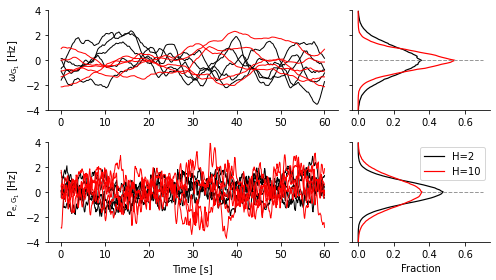

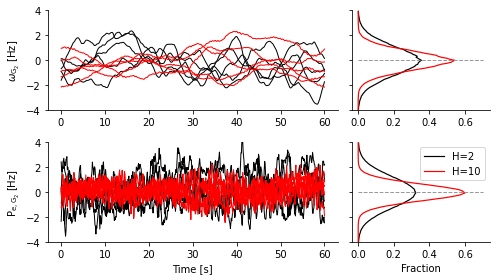

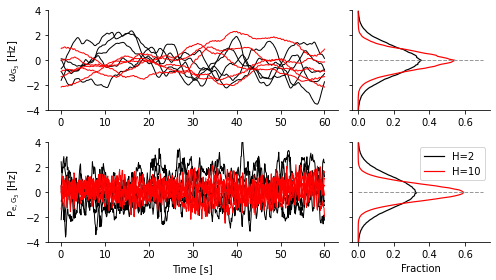

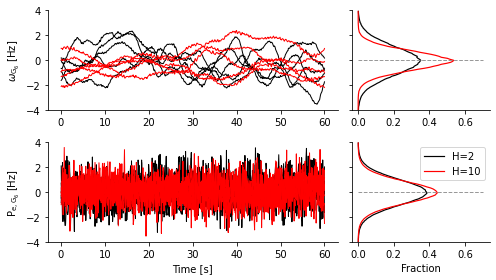

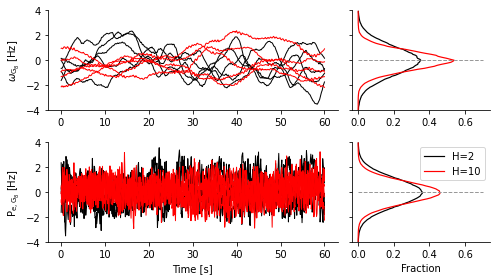

In [3]:
data_folder = '../data/IEEE14/var_H_G1/IEEE14_D=2_DZA=60.0/'
for gen in 1,2,3,6,8:
    plot_data(data_folder, gen_id=gen, xlim_distr = 0.67)

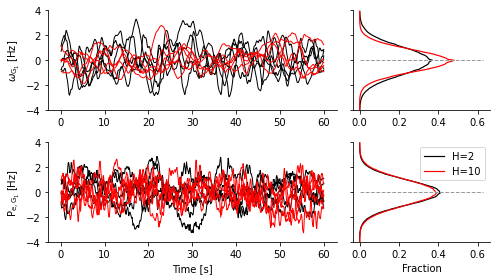

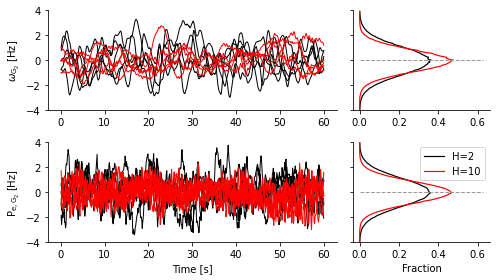

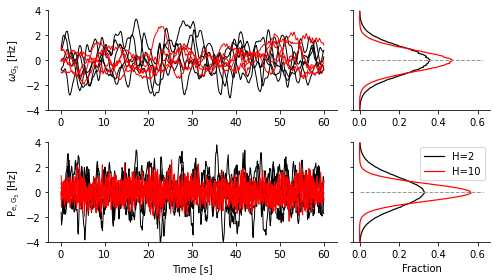

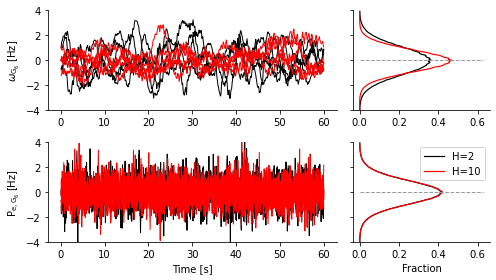

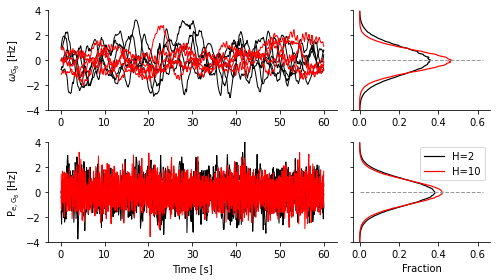

In [4]:
data_folder = '../data/IEEE14/var_H_G1/IEEE14_D=2_DZA=0.036/'
for gen in 1,2,3,6,8:
    plot_data(data_folder, gen_id=gen, xlim_distr = 0.6)

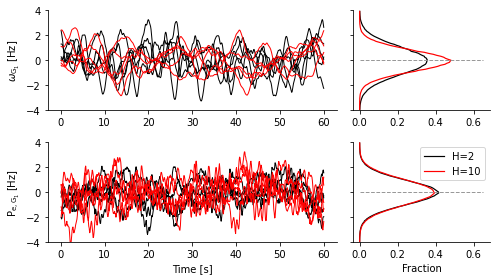

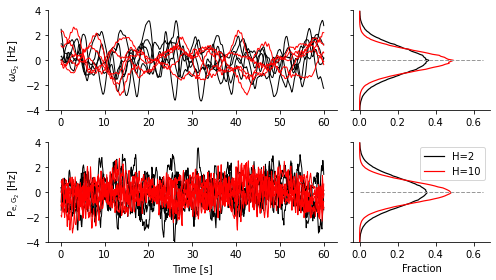

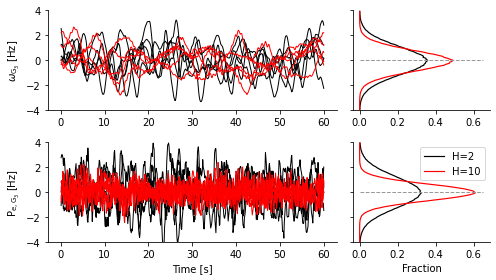

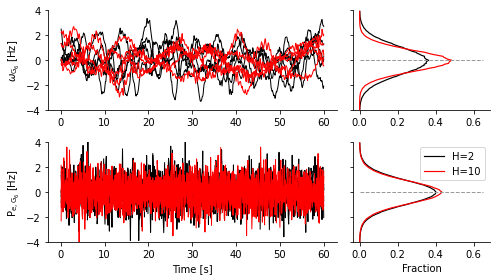

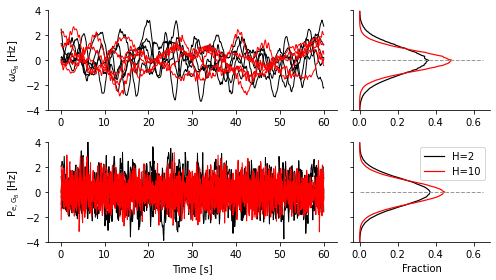

In [5]:
data_folder = '../data/IEEE14/var_H_G1/IEEE14_D=0_DZA=0.36/'
for gen in 1,2,3,6,8:
    plot_data(data_folder, gen_id=gen, xlim_distr = 0.62)

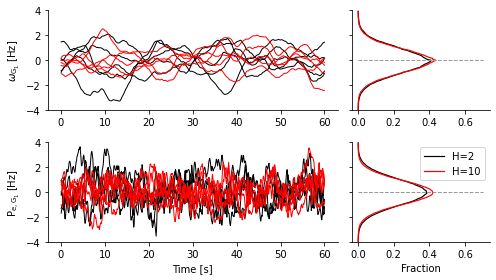

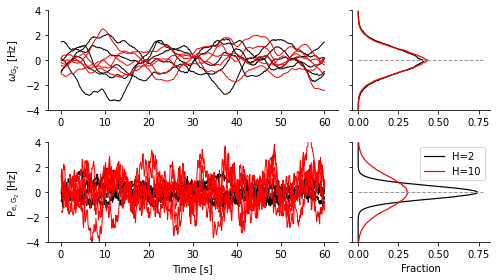

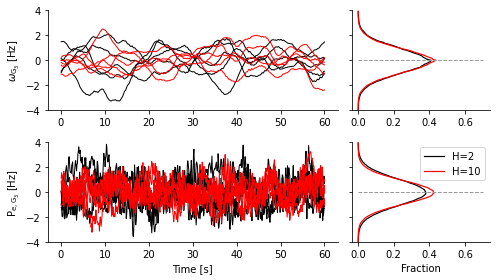

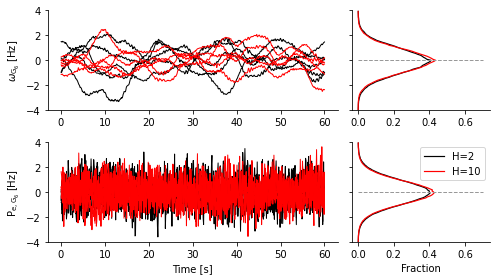

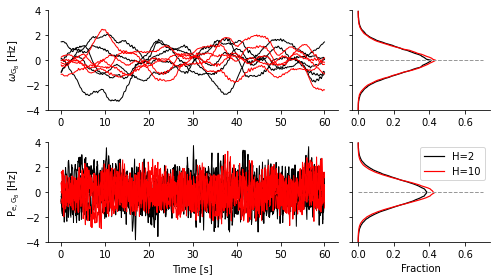

In [6]:
data_folder = '../data/IEEE14/var_H_G2/IEEE14_D=2_DZA=60.0/'
for gen in 1,2,3,6,8:
    plot_data(data_folder, gen_id=gen, xlim_distr = 0.67)

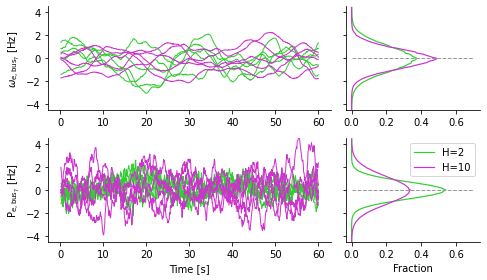

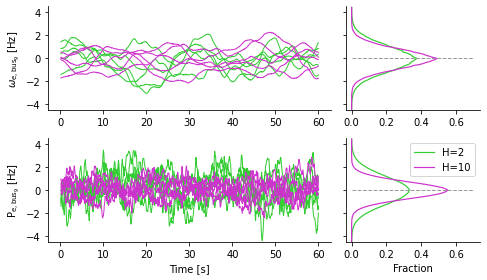

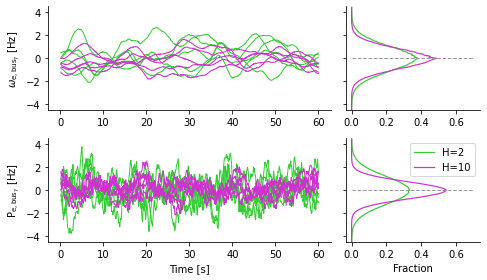

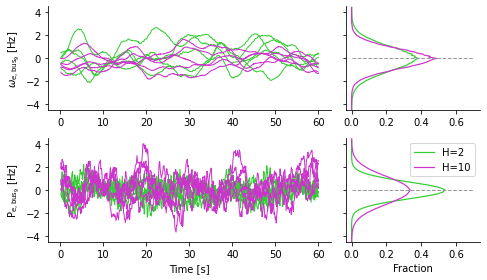

In [15]:
for area in 1,2:
    data_folder = f'../data/two-area/var_H_area_{area}/two-area_D=2_DZA=60.0/'
    for bus in 7,9:
        plot_data(data_folder, bus_id=bus, area_id=area, H_values=[2,10], xlim_distr = 0.67, ylim=[-4.5,4.5])